# xRV Analysis

## Notebook Contents

- [Imports](#Imports)
- [Data](#Data)
- [Preprocessing](#Preprocessing)
- [Analysis](#Analysis)
    - [Run Value by Event](#Run-Value-for-Ball-in-Play-by-Events)
    - [Run Value by Count](#Run-Value-by-Count)
    - [Avg Run Value by Pitch Type](#Average-Run-Value-by-Pitch-Type)
- [Fastball](#Fastball-Analysis)
    - [Fastball Metrics](#Fastball-Metrics)
    - [Top Fastball xRV](#Top-Fastballs-by-xRV)
    - [RHP Fastball xRV Break Plot](#RHP-Fastball-Break-Plot-by-xRV)
    - [LHP Fastball xRV Break Plot](#LHP-Fastball-Break-Plot-by-xRV)
- [Breaking Ball Analysis](#Breaking-Ball-Analysis)
    - [Breaking Ball Metrics](#Breaking-Ball-Metrics)
    - [Top Breaking Ball xRV](#Top-Breaking-Balls-by-xRV)
    - [RHP Breaking Ball xRV Break Plot](#RHP-Breaking-Ball-Break-Plot-by-xRV)
    - [LHP Breaking Ball xRV Break Plot](#LHP-Breaking-Ball-Break-Plot-by-xRV)
- [Off-Speed Analysis](#Off-Speed-Analysis)
    - [Off-Speed Metrics](#Off-Speed-Metrics)
    - [Top Off-Speed xRV](#Top-Off-Speeds-by-xRV)
    - [RHP Off-Speed xRV Break Plot](#RHP-Off-Speed-Break-Plot-by-xRV)
    - [LHP Off-Speed xRV Break Plot](#LHP-Off-Speed-Break-Plot-by-xRV)

# Imports

In [1]:
from sklearn.preprocessing import scale, StandardScaler
from matplotlib.patches import Rectangle
from statsmodels.stats.outliers_influence import variance_inflation_factor

import warnings
warnings.filterwarnings('ignore')

# Data

In [2]:
data = pd.read_csv('../data/model-pitches-rv.csv', index_col = [0])
rv_table = pd.read_csv('../data/rv_table.csv', index_col = [0])
xrv_grouped = pd.read_csv('../data/xrv_grouped.csv', index_col = [0])
xrv_grouped.rename(columns = {'release_pos_x': 'rel_x', 'release_pos_z': 'rel_z', 
                              'release_extension': 'extension'}, inplace = True)
print(xrv_grouped.shape)
xrv_grouped.head()

(705430, 14)


,player_name,p_throws,pitch_type,velo,pfx_x,pfx_z,rel_x,rel_z,extension,rv,n_pitches,xRV,RV/100,xRV/100
0,"Gsellman, Robert",R,SI,94.3,16.20,10.56,1.20,6.05,6.5,-0.110,1,-0.066312,-11.0,-6.63
1,"Gsellman, Robert",R,SI,94.3,18.24,5.88,1.29,6.02,6.4,-0.047,1,-0.010998,-4.7,-1.10
2,"Gsellman, Robert",R,SI,94.2,17.04,6.36,1.41,5.88,6.4,-0.034,1,-0.057794,-3.4,-5.78
3,"Gsellman, Robert",R,SI,94.1,15.36,4.32,1.31,5.96,6.4,-0.135,1,0.039334,-13.5,3.93
4,"Gsellman, Robert",R,SI,93.6,15.48,6.96,1.42,5.89,6.5,-0.135,1,-0.129640,-13.5,-12.96


In [3]:
print(rv_table.shape)
rv_table.head()

(3469, 14)


,player_name,p_throws,pitch_type,n_pitches,velo,pfx_x,pfx_z,release_pos_x,release_pos_z,release_extension,rv,xRV,RV/100,xRV/100
0,"Abbott, Cory",R,FF,207,92.6,9.6,17.2,2.6,5.5,6.2,5.7,4.0,2.7,1.9
1,"Abreu, Albert",R,FF,103,97.8,11.7,15.4,2.5,5.7,6.4,-1.5,-2.3,-1.5,-2.2
2,"Abreu, Albert",R,SI,212,98.0,15.3,13.3,2.5,5.6,6.5,1.0,-1.3,0.4,-0.6
3,"Abreu, Bryan",R,FF,310,95.7,8.0,17.1,1.5,6.0,6.3,-1.4,0.0,-0.4,0.0
4,"Abreu, Bryan",R,SI,2,96.0,14.2,14.9,1.9,5.9,6.4,-0.0,-0.0,-1.2,-0.4


# Preprocessing

In [4]:
rhp_fb = xrv_grouped[xrv_grouped['pitch_type'].isin(['FF', 'SI']) & (xrv_grouped['p_throws'] == 'R')]
lhp_fb = xrv_grouped[xrv_grouped['pitch_type'].isin(['FF', 'SI']) & (xrv_grouped['p_throws'] == 'L')]
fb = xrv_grouped[xrv_grouped['pitch_type'].isin(['FF', 'SI'])]
rhp_bb = xrv_grouped[xrv_grouped['pitch_type'].isin(['SL', 'FC', 'CU', 'KC']) & (xrv_grouped['p_throws'] == 'R')]
lhp_bb = xrv_grouped[xrv_grouped['pitch_type'].isin(['SL', 'FC', 'CU', 'KC']) & (xrv_grouped['p_throws'] == 'L')]
bb = xrv_grouped[xrv_grouped['pitch_type'].isin(['SL', 'FC', 'CU', 'KC'])]
rhp_os = xrv_grouped[xrv_grouped['pitch_type'].isin(['CH', 'FS']) & (xrv_grouped['p_throws'] == 'R')]
lhp_os = xrv_grouped[xrv_grouped['pitch_type'].isin(['CH', 'FS']) & (xrv_grouped['p_throws'] == 'L')]
os = xrv_grouped[xrv_grouped['pitch_type'].isin(['CH', 'FS'])]

fb_rvtable = rv_table[rv_table['pitch_type'].isin(['FF', 'SI'])]
bb_rvtable = rv_table[rv_table['pitch_type'].isin(['SL', 'FC', 'CU', 'KC'])]
os_rvtable = rv_table[rv_table['pitch_type'].isin(['CH', 'FS'])]

# Analysis

### Run Value for Ball in Play by Events

In [5]:
data.groupby(['events'], as_index = False)['rv'].mean().round(3)

,events,rv
0,double,0.770
1,field_error,0.445
2,field_out,-0.271
3,hit_by_pitch,0.359
4,home_run,1.386
5,single,0.475
6,triple,1.063
7,walk,0.332


### Run Value by Count

In [6]:
count_rv = data.groupby(['pitch_count'], as_index = False)['woba', 'rv'].mean().round(3)
#print(count_rv.to_markdown())
count_rv.head()

,pitch_count,woba,rv
0,0-0,0.314,0.002
1,0-1,0.265,-0.003
2,0-2,0.197,-0.067
3,1-0,0.356,0.007
4,1-1,0.300,0.002


|    | pitch_count   |   woba |     rv |
|---:|:--------------|-------:|-------:|
|  0 | 0-0           |  0.314 |  0.002 |
|  1 | 0-1           |  0.265 | -0.003 |
|  2 | 0-2           |  0.197 | -0.067 |
|  3 | 1-0           |  0.356 |  0.007 |
|  4 | 1-1           |  0.3   |  0.002 |
|  5 | 1-2           |  0.222 | -0.07  |
|  6 | 2-0           |  0.426 |  0.017 |
|  7 | 2-1           |  0.357 |  0.009 |
|  8 | 2-2           |  0.269 | -0.07  |
|  9 | 3-0           |  0.54  |  0.096 |
| 10 | 3-1           |  0.477 |  0.084 |
| 11 | 3-2           |  0.379 |  0.024 |

### Average Run Value by Pitch Type

In [7]:
xrv_grouped.groupby(['pitch_type'], as_index = False, sort = False)['rv', 'RV/100', 
                                                                    'xRV', 'xRV/100'].mean().round(4)

,pitch_type,rv,RV/100,xRV,xRV/100
0,SI,-0.0021,-0.2125,0.0027,0.2685
1,FF,-0.0090,-0.9034,-0.0048,-0.4827
2,SL,-0.0184,-1.8417,-0.0149,-1.4940
3,CU,-0.0165,-1.6454,-0.0138,-1.3823
4,FC,-0.0080,-0.7979,-0.0058,-0.5831
5,KC,-0.0192,-1.9250,-0.0153,-1.5312
6,CH,-0.0105,-1.0453,-0.0078,-0.7818
7,FS,-0.0260,-2.6026,-0.0206,-2.0641


# Fastball Analysis

### Fastball Metrics

In [8]:
mean_rhp_fb = rhp_fb.groupby(['pitch_type', 'p_throws'], 
                             as_index = False, sort = False)['velo', 'pfx_x', 'pfx_z', 
                                                             'rel_x', 'rel_z', 'extension', 'xRV'].mean()
fb_r_pitches = rhp_fb.groupby(['pitch_type', 'p_throws'], as_index = False, sort = False)['n_pitches'].sum()
avg_rhp_fb = pd.merge(mean_rhp_fb, fb_r_pitches, how = 'right', on = ['pitch_type', 'p_throws'])


mean_lhp_fb = lhp_fb.groupby(['pitch_type', 'p_throws'], 
                             as_index = False, sort = False)['velo', 'pfx_x', 'pfx_z', 
                                                             'rel_x', 'rel_z', 'extension', 'xRV'].mean()
fb_l_pitches = lhp_fb.groupby(['pitch_type', 'p_throws'], as_index = False, sort = False)['n_pitches'].sum()
avg_lhp_fb = pd.merge(mean_lhp_fb, fb_l_pitches, how = 'right', on = ['pitch_type', 'p_throws'])

fb_avg = pd.concat([avg_rhp_fb, avg_lhp_fb], ignore_index = True)
fb_avg.insert(2, 'n_pitches', fb_avg.pop('n_pitches'))
fb_avg.round({'velo': 1, 'pfx_x': 1, 'pfx_z': 1, 'rel_x': 1, 'rel_z': 1, 'extension': 1, 'xRV': 3}).head()

,pitch_type,p_throws,n_pitches,velo,pfx_x,pfx_z,rel_x,rel_z,extension,xRV
0,SI,R,75680,93.4,14.8,9.2,1.9,5.7,6.3,0.003
1,FF,R,176386,94.1,7.1,16.1,1.8,5.9,6.4,-0.004
2,FF,L,73294,92.8,-7.5,16.2,-1.9,6.0,6.3,-0.006
3,SI,L,33470,92.1,-15.0,9.3,-2.1,5.8,6.3,0.002


### Above Average Fastball Metrics

In [9]:
abv_rhp_fb = rhp_fb.loc[rhp_fb['xRV'] < -.05]
abv_lhp_fb = lhp_fb.loc[lhp_fb['xRV'] < -.05]

great_rhp_fb = abv_rhp_fb.groupby(['pitch_type', 'p_throws'], 
                             as_index = False, sort = False)['velo', 'pfx_x', 'pfx_z', 
                                                             'rel_x', 'rel_z', 'extension', 'xRV'].mean()
fb_r_pitches = abv_rhp_fb.groupby(['pitch_type', 'p_throws'], as_index = False, sort = False)['n_pitches'].sum()
abv_rhp_fb = pd.merge(great_rhp_fb, fb_r_pitches, how = 'right', on = ['pitch_type', 'p_throws'])


great_lhp_fb = abv_lhp_fb.groupby(['pitch_type', 'p_throws'], 
                             as_index = False, sort = False)['velo', 'pfx_x', 'pfx_z', 
                                                             'rel_x', 'rel_z', 'extension', 'xRV'].mean()
fb_l_pitches = abv_lhp_fb.groupby(['pitch_type', 'p_throws'], as_index = False, sort = False)['n_pitches'].sum()
abv_lhp_fb = pd.merge(great_lhp_fb, fb_l_pitches, how = 'right', on = ['pitch_type', 'p_throws'])

fb_abv = pd.concat([abv_rhp_fb, abv_lhp_fb], ignore_index = True)
fb_abv.insert(2, 'n_pitches', fb_abv.pop('n_pitches'))
fb_abv.round({'velo': 1, 'pfx_x': 1, 'pfx_z': 1, 'rel_x': 1, 'rel_z': 1, 'extension': 1, 'xRV': 3}).head()

,pitch_type,p_throws,n_pitches,velo,pfx_x,pfx_z,rel_x,rel_z,extension,xRV
0,SI,R,15231,93.6,14.8,9.1,1.9,5.7,6.3,-0.145
1,FF,R,39729,94.6,7.2,16.2,1.8,5.9,6.4,-0.132
2,FF,L,16878,93.2,-7.4,16.2,-1.9,6.0,6.3,-0.134
3,SI,L,7068,92.5,-15.2,9.2,-2.2,5.7,6.3,-0.138


### Below Average Fastball Metrics

In [10]:
blw_rhp_fb = rhp_fb.loc[rhp_fb['xRV'] > .05]
blw_lhp_fb = lhp_fb.loc[lhp_fb['xRV'] > .05]

great_rhp_fb = blw_rhp_fb.groupby(['pitch_type', 'p_throws'], 
                             as_index = False, sort = False)['velo', 'pfx_x', 'pfx_z', 
                                                             'rel_x', 'rel_z', 'extension', 'xRV'].mean()
fb_r_pitches = blw_rhp_fb.groupby(['pitch_type', 'p_throws'], as_index = False, sort = False)['n_pitches'].sum()
blw_rhp_fb = pd.merge(great_rhp_fb, fb_r_pitches, how = 'right', on = ['pitch_type', 'p_throws'])


great_lhp_fb = blw_lhp_fb.groupby(['pitch_type', 'p_throws'], 
                             as_index = False, sort = False)['velo', 'pfx_x', 'pfx_z', 
                                                             'rel_x', 'rel_z', 'extension', 'xRV'].mean()
fb_l_pitches = blw_lhp_fb.groupby(['pitch_type', 'p_throws'], as_index = False, sort = False)['n_pitches'].sum()
blw_lhp_fb = pd.merge(great_lhp_fb, fb_l_pitches, how = 'right', on = ['pitch_type', 'p_throws'])

fb_blw = pd.concat([blw_rhp_fb, blw_lhp_fb], ignore_index = True)
fb_blw.insert(2, 'n_pitches', fb_blw.pop('n_pitches'))
fb_blw.round({'velo': 1, 'pfx_x': 1, 'pfx_z': 1, 'rel_x': 1, 'rel_z': 1, 'extension': 1, 'xRV': 3}).head()

,pitch_type,p_throws,n_pitches,velo,pfx_x,pfx_z,rel_x,rel_z,extension,xRV
0,FF,R,22986,93.7,7.0,15.5,1.7,5.9,6.4,0.220
1,SI,R,12299,93.2,14.7,8.8,1.9,5.7,6.3,0.211
2,SI,L,5396,91.9,-14.8,9.0,-2.1,5.8,6.2,0.205
3,FF,L,9590,92.5,-7.4,15.8,-1.9,6.0,6.3,0.218


### Deadzone Fastballs

In [11]:
dzone_rhp_fb = rhp_fb.loc[(rhp_fb['pfx_x'].between(12, 15)) & (rhp_fb['pfx_z'].between(12, 15))]
dzone_lhp_fb = lhp_fb.loc[(lhp_fb['pfx_x'].between(-15, -12)) & (lhp_fb['pfx_z'].between(12, 15))]

dead_rhp_fb = dzone_rhp_fb.groupby(['pitch_type', 'p_throws'], 
                             as_index = False, sort = False)['velo', 'pfx_x', 'pfx_z', 
                                                             'rel_x', 'rel_z', 'extension', 'xRV'].mean()
dead_r_pitches = dzone_rhp_fb.groupby(['pitch_type', 'p_throws'], as_index = False)['n_pitches'].sum()
rhp_deadzone_fb = pd.merge(dead_rhp_fb, dead_r_pitches, how = 'right', on = ['pitch_type', 'p_throws'])

dead_lhp_fb = dzone_lhp_fb.groupby(['pitch_type', 'p_throws'], 
                             as_index = False, sort = False)['velo', 'pfx_x', 'pfx_z', 
                                                             'rel_x', 'rel_z', 'extension', 'xRV'].mean()
dead_l_pitches = dzone_lhp_fb.groupby(['pitch_type', 'p_throws'], as_index = False)['n_pitches'].sum()
lhp_deadzone_fb = pd.merge(dead_lhp_fb, dead_l_pitches, how = 'right', on = ['pitch_type', 'p_throws'])

deadzone_fb = pd.concat([rhp_deadzone_fb, lhp_deadzone_fb], ignore_index = True)
deadzone_fb.insert(2, 'n_pitches', deadzone_fb.pop('n_pitches'))
deadzone_fb.round({'velo': 1, 'pfx_x': 1, 'pfx_z': 1, 'rel_x': 1, 'rel_z': 1, 'extension': 1, 'xRV': 3}).head()

,pitch_type,p_throws,n_pitches,velo,pfx_x,pfx_z,rel_x,rel_z,extension,xRV
0,FF,R,6120,94.6,13.2,13.7,2.2,5.6,6.4,0.002
1,SI,R,6861,93.7,13.6,13.4,1.7,5.9,6.4,0.004
2,FF,L,2793,93.3,-13.3,13.7,-2.3,5.8,6.3,-0.000
3,SI,L,3603,92.9,-13.7,13.3,-2.0,6.0,6.5,0.006


### Top Fastballs by xRV

In [12]:
fb_rvtable.sort_values(by = 'xRV').head(10)

,player_name,p_throws,pitch_type,n_pitches,velo,pfx_x,pfx_z,release_pos_x,release_pos_z,release_extension,rv,xRV,RV/100,xRV/100
261,"Ray, Robbie",L,FF,1864,94.8,-8.2,17.1,-2.5,6.1,6.5,-47.3,-40.5,-2.5,-2.2
166,"Cole, Gerrit",R,FF,1397,97.7,12.0,18.0,1.9,5.7,6.6,-35.5,-35.2,-2.5,-2.5
272,"Rogers, Trevor",L,FF,1249,94.5,-11.1,14.8,-2.2,5.9,6.6,-32.6,-35.2,-2.6,-2.8
901,"Wheeler, Zack",R,FF,1353,97.2,7.6,15.9,1.6,5.7,7.2,-36.9,-30.9,-2.7,-2.3
269,"Rodón, Carlos",L,FF,1302,95.4,-7.9,17.6,-2.0,6.7,6.1,-38.1,-30.1,-2.9,-2.3
375,"Hendriks, Liam",R,FF,761,97.7,6.8,18.5,1.6,5.9,6.9,-26.1,-27.4,-3.4,-3.6
303,"Gausman, Kevin",R,FF,1580,94.6,10.4,16.4,2.5,6.0,6.5,-28.8,-27.0,-1.8,-1.7
949,"deGrom, Jacob",R,FF,704,99.2,9.1,16.4,1.1,5.5,6.9,-25.1,-27.0,-3.6,-3.8
191,"Matz, Steven",L,SI,1327,94.5,-15.0,12.3,-1.9,5.8,6.5,-19.9,-26.7,-1.5,-2.0
329,"Green, Chad",R,FF,854,95.7,4.5,19.3,1.6,6.2,6.7,-27.0,-25.2,-3.2,-3.0


### RHP Fastball Break Plot by xRV

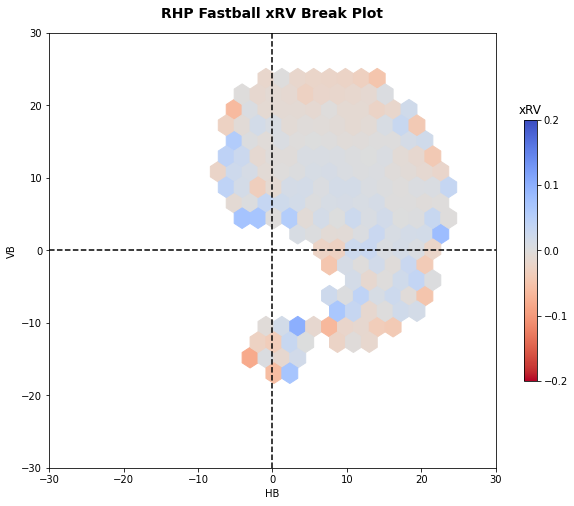

In [13]:
plt.figure(figsize = (10, 8))
plt.hexbin(rhp_fb['pfx_x'], rhp_fb['pfx_z'], C = rhp_fb['xRV'], cmap = 'coolwarm_r', 
           mincnt = 10, gridsize = 20)
cb = plt.colorbar(ticks = [-.2,-.1, 0, .1, .2], shrink = .6)
cb.ax.set_title('xRV'), plt.clim(-.2, .2)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('RHP Fastball xRV Break Plot', fontsize = 14, fontweight = 'bold', pad = 15);

### LHP Fastball Break Plot by xRV

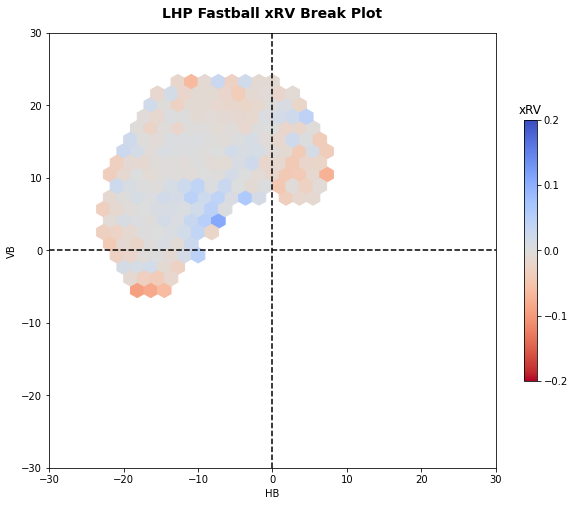

In [14]:
plt.figure(figsize = (10, 8))

plt.hexbin(lhp_fb['pfx_x'], lhp_fb['pfx_z'], C = lhp_fb['xRV'], cmap = 'coolwarm_r',
           mincnt = 10, gridsize = 20)
cb = plt.colorbar(ticks = [-.2,-.1, 0, .1, .2], shrink = .6)
cb.ax.set_title('xRV'), plt.clim(-.2, .2)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('LHP Fastball xRV Break Plot', fontsize = 14, fontweight = 'bold', pad = 15);

# Breaking Ball Analysis

### Breaking Ball Metrics

In [15]:
good_rhp_bb = rhp_bb.groupby(['pitch_type', 'p_throws'], 
                             as_index = False, sort = False)['velo', 'pfx_x', 'pfx_z', 
                                                             'rel_x', 'rel_z', 'extension', 'xRV'].mean()
bb_r_pitches = rhp_bb.groupby(['pitch_type', 'p_throws'], as_index = False, sort = False)['n_pitches'].sum()
avg_rhp_bb = pd.merge(good_rhp_bb, bb_r_pitches, how = 'right', on = ['pitch_type', 'p_throws'])


good_lhp_bb = lhp_bb.groupby(['pitch_type', 'p_throws'], 
                             as_index = False, sort = False)['velo', 'pfx_x', 'pfx_z', 
                                                             'rel_x', 'rel_z', 'extension', 'xRV'].mean()
bb_l_pitches = lhp_bb.groupby(['pitch_type', 'p_throws'], as_index = False, sort = False)['n_pitches'].sum()
avg_lhp_bb = pd.merge(good_lhp_bb, bb_l_pitches, how = 'right', on = ['pitch_type', 'p_throws'])

bb_avg = pd.concat([avg_rhp_bb, avg_lhp_bb], ignore_index = True)
bb_avg.insert(2, 'n_pitches', bb_avg.pop('n_pitches'))
bb_avg.round({'velo': 1, 'pfx_x': 1, 'pfx_z': 1, 'rel_x': 1, 'rel_z': 1, 'extension': 1, 'xRV': 3}).head(8)

,pitch_type,p_throws,n_pitches,velo,pfx_x,pfx_z,rel_x,rel_z,extension,xRV
0,SL,R,100754,84.9,-6.3,1.8,1.9,5.8,6.3,-0.014
1,CU,R,39992,79.2,-9.6,-9.3,1.7,6.0,6.2,-0.012
2,FC,R,31182,89.5,-3.0,7.9,1.8,5.9,6.3,-0.005
3,KC,R,11633,81.5,-8.3,-11.7,1.8,5.9,6.3,-0.017
4,SL,L,34780,83.9,5.8,1.5,-2.0,5.9,6.2,-0.017
5,CU,L,18778,77.7,8.4,-7.5,-1.9,6.0,6.1,-0.017
6,FC,L,16262,86.8,1.7,7.9,-2.1,5.8,6.2,-0.008
7,KC,L,2039,78.9,5.0,-9.0,-1.7,6.3,6.0,-0.006


### Above Average Breaking Ball Metrics

In [16]:
abv_rhp_bb = rhp_bb.loc[rhp_bb['xRV'] < -.05]
abv_lhp_bb = lhp_bb.loc[lhp_bb['xRV'] < -.05]

great_rhp_bb = abv_rhp_bb.groupby(['pitch_type', 'p_throws'], 
                             as_index = False, sort = False)['velo', 'pfx_x', 'pfx_z', 
                                                             'rel_x', 'rel_z', 'extension', 'xRV'].mean()
bb_r_pitches = abv_rhp_bb.groupby(['pitch_type', 'p_throws'], as_index = False, sort = False)['n_pitches'].sum()
abv_rhp_bb = pd.merge(great_rhp_bb, bb_r_pitches, how = 'right', on = ['pitch_type', 'p_throws'])


great_lhp_bb = abv_lhp_bb.groupby(['pitch_type', 'p_throws'], 
                             as_index = False, sort = False)['velo', 'pfx_x', 'pfx_z', 
                                                             'rel_x', 'rel_z', 'extension', 'xRV'].mean()
bb_l_pitches = abv_lhp_bb.groupby(['pitch_type', 'p_throws'], as_index = False, sort = False)['n_pitches'].sum()
abv_lhp_bb = pd.merge(great_lhp_bb, bb_l_pitches, how = 'right', on = ['pitch_type', 'p_throws'])

bb_abv = pd.concat([abv_rhp_bb, abv_lhp_bb], ignore_index = True)
bb_abv.insert(2, 'n_pitches', bb_abv.pop('n_pitches'))
bb_abv.round({'velo': 1, 'pfx_x': 1, 'pfx_z': 1, 'rel_x': 1, 'rel_z': 1, 'extension': 1, 'xRV': 3}).head(8)

,pitch_type,p_throws,n_pitches,velo,pfx_x,pfx_z,rel_x,rel_z,extension,xRV
0,SL,R,26247,85.1,-6.8,1.6,1.9,5.7,6.3,-0.137
1,FC,R,6887,89.7,-3.2,7.7,1.7,5.9,6.3,-0.136
2,CU,R,9277,79.7,-10.3,-9.4,1.6,5.9,6.3,-0.135
3,KC,R,3004,82.1,-8.4,-11.5,1.8,5.9,6.3,-0.133
4,SL,L,9796,84.3,6.0,1.2,-2.0,5.9,6.3,-0.136
5,CU,L,4981,78.2,8.9,-7.4,-1.8,6.0,6.1,-0.133
6,FC,L,4097,86.7,2.1,7.4,-2.2,5.8,6.2,-0.134
7,KC,L,409,79.6,4.9,-9.9,-1.6,6.3,6.0,-0.133


### Below Average Breaking Ball Metrics

In [17]:
blw_rhp_bb = rhp_bb.loc[rhp_bb['xRV'] > .05]
blw_lhp_bb = lhp_bb.loc[lhp_bb['xRV'] > .05]

great_rhp_bb = blw_rhp_bb.groupby(['pitch_type', 'p_throws'], 
                             as_index = False, sort = False)['velo', 'pfx_x', 'pfx_z', 
                                                             'rel_x', 'rel_z', 'extension', 'xRV'].mean()
bb_r_pitches = blw_rhp_bb.groupby(['pitch_type', 'p_throws'], as_index = False, sort = False)['n_pitches'].sum()
blw_rhp_bb = pd.merge(great_rhp_bb, bb_r_pitches, how = 'right', on = ['pitch_type', 'p_throws'])


great_lhp_bb = blw_lhp_bb.groupby(['pitch_type', 'p_throws'], 
                             as_index = False, sort = False)['velo', 'pfx_x', 'pfx_z', 
                                                             'rel_x', 'rel_z', 'extension', 'xRV'].mean()
bb_l_pitches = blw_lhp_bb.groupby(['pitch_type', 'p_throws'], as_index = False, sort = False)['n_pitches'].sum()
blw_lhp_bb = pd.merge(great_lhp_bb, bb_l_pitches, how = 'right', on = ['pitch_type', 'p_throws'])

bb_blw = pd.concat([blw_rhp_bb, blw_lhp_bb], ignore_index = True)
bb_blw.insert(2, 'n_pitches', bb_blw.pop('n_pitches'))
bb_blw.round({'velo': 1, 'pfx_x': 1, 'pfx_z': 1, 'rel_x': 1, 'rel_z': 1, 'extension': 1, 'xRV': 3}).head(8)

,pitch_type,p_throws,n_pitches,velo,pfx_x,pfx_z,rel_x,rel_z,extension,xRV
0,FC,R,3956,89.7,-2.6,8.6,1.7,6.0,6.3,0.227
1,SL,R,10928,84.7,-5.8,2.0,2.0,5.8,6.3,0.236
2,CU,R,4027,78.7,-9.1,-9.4,1.7,6.0,6.2,0.219
3,KC,R,1079,81.1,-8.0,-11.8,1.8,6.0,6.4,0.225
4,SL,L,3623,83.9,5.5,1.5,-2.0,5.8,6.3,0.237
5,FC,L,2156,87.2,1.0,8.5,-2.1,5.8,6.2,0.227
6,CU,L,1823,77.3,8.0,-7.8,-1.9,6.0,6.1,0.227
7,KC,L,241,78.6,5.1,-8.9,-1.7,6.3,6.0,0.185


### Top Breaking Balls by xRV

In [18]:
bb_rvtable.sort_values(by = 'xRV').head(10)

,player_name,p_throws,pitch_type,n_pitches,velo,pfx_x,pfx_z,release_pos_x,release_pos_z,release_extension,rv,xRV,RV/100,xRV/100
654,"Morton, Charlie",R,CU,1095,80.6,-16.6,-10.1,2.1,5.5,6.2,-39.3,-39.8,-3.6,-3.6
355,"Urías, Julio",L,CU,952,81.4,15.8,-0.9,-1.6,6.1,5.5,-38.7,-39.6,-4.1,-4.2
293,"Rodón, Carlos",L,SL,603,85.8,8.2,-1.1,-2.3,6.5,6.0,-30.1,-27.3,-5.0,-4.5
657,"Musgrove, Joe",R,CU,698,82.1,-11.0,-13.7,1.2,6.5,5.9,-26.9,-26.3,-3.8,-3.8
357,"Valdez, Framber",L,CU,643,77.9,13.5,-15.3,-1.1,5.9,5.8,-26.3,-25.7,-4.1,-4.0
286,"Ray, Robbie",L,SL,964,88.6,1.0,7.2,-2.6,6.0,6.3,-31.3,-25.5,-3.2,-2.6
604,"McCullers Jr., Lance",R,SL,719,86.0,-13.7,4.6,1.7,5.1,6.0,-26.2,-25.5,-3.6,-3.6
455,"Jackson, Luke",R,SL,562,87.5,-1.4,-5.6,2.4,6.3,6.7,-24.0,-25.1,-4.3,-4.5
659,"Musgrove, Joe",R,SL,815,84.1,-14.0,-1.6,1.4,6.4,5.9,-30.3,-25.1,-3.7,-3.1
212,"McClanahan, Shane",L,SL,674,89.2,3.8,2.0,-0.8,6.2,6.8,-22.5,-25.1,-3.3,-3.7


### RHP Breaking Ball Break Plot by xRV

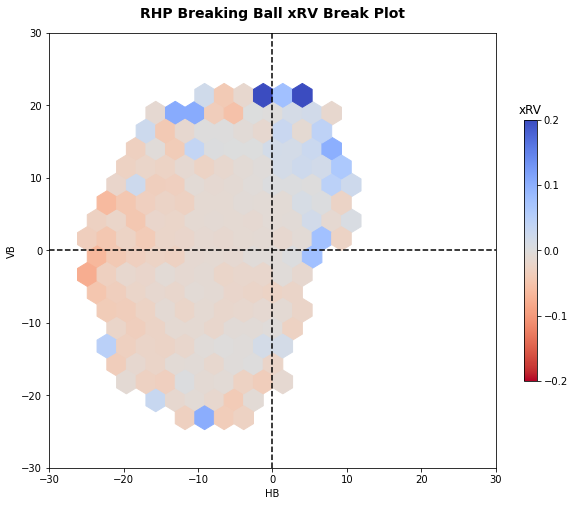

In [19]:
plt.figure(figsize = (10, 8))

plt.hexbin(rhp_bb['pfx_x'], rhp_bb['pfx_z'], C = rhp_bb['xRV'],cmap='coolwarm_r',
           mincnt = 10, gridsize = 20)
cb = plt.colorbar(ticks = [-.2,-.1, 0, .1, .2], shrink = .6)
cb.ax.set_title('xRV'), plt.clim(-.2, .2)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('RHP Breaking Ball xRV Break Plot', fontsize = 14, fontweight = 'bold', pad = 15);

### LHP Breaking Ball Break Plot by xRV

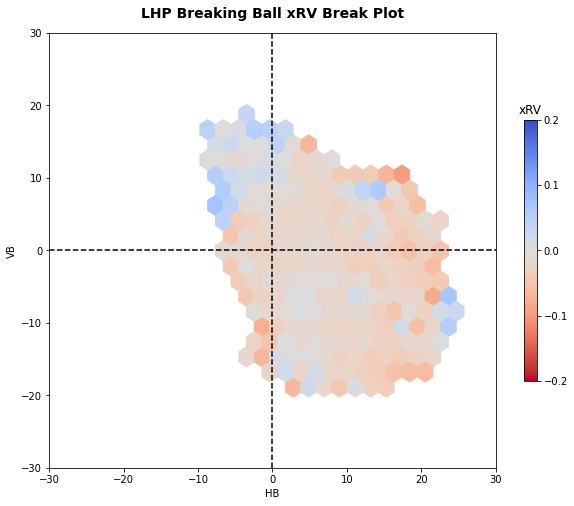

In [20]:
plt.figure(figsize = (10, 8))

plt.hexbin(lhp_bb['pfx_x'], lhp_bb['pfx_z'], C = lhp_bb['xRV'],cmap='coolwarm_r', 
           mincnt = 10, gridsize = 20)
cb = plt.colorbar(ticks = [-.2,-.1, 0, .1, .2], shrink = .6)
cb.ax.set_title('xRV'), plt.clim(-.2, .2)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('LHP Breaking Ball xRV Break Plot', fontsize = 14, fontweight = 'bold', pad = 15);

# Off-Speed Analysis

### Off-Speed Metrics

In [21]:
good_rhp_os = rhp_os.groupby(['pitch_type', 'p_throws'], 
                             as_index = False, sort = False)['velo', 'pfx_x', 'pfx_z', 
                                                             'rel_x', 'rel_z', 'extension', 'xRV'].mean()
os_r_pitches = rhp_os.groupby(['pitch_type', 'p_throws'], as_index = False, sort = False)['n_pitches'].sum()
avg_rhp_os = pd.merge(good_rhp_os, os_r_pitches, how = 'right', on = ['pitch_type', 'p_throws'])


good_lhp_os = lhp_os.groupby(['pitch_type', 'p_throws'], 
                             as_index = False, sort = False)['velo', 'pfx_x', 'pfx_z', 
                                                             'rel_x', 'rel_z', 'extension', 'xRV'].mean()
os_l_pitches = lhp_os.groupby(['pitch_type', 'p_throws'], as_index = False, sort = False)['n_pitches'].sum()
avg_lhp_os = pd.merge(good_lhp_os, os_l_pitches, how = 'right', on = ['pitch_type', 'p_throws'])

os_avg = pd.concat([avg_rhp_os, avg_lhp_os], ignore_index = True)
os_avg.insert(2, 'n_pitches', os_avg.pop('n_pitches'))
os_avg.round({'velo': 1, 'pfx_x': 1, 'pfx_z': 1, 'rel_x': 1, 'rel_z': 1, 'extension': 1, 'xRV': 3}).head()

,pitch_type,p_throws,n_pitches,velo,pfx_x,pfx_z,rel_x,rel_z,extension,xRV
0,CH,R,50661,85.5,13.8,6.3,1.9,5.8,6.3,-0.008
1,FS,R,10239,85.8,10.7,3.9,1.7,5.9,6.3,-0.020
2,CH,L,29677,83.6,-13.9,7.8,-2.0,5.8,6.2,-0.008
3,FS,L,603,83.8,-8.7,4.0,-1.7,5.8,6.6,-0.028


### Above Average Off-Speed Metrics

In [22]:
abv_rhp_os = rhp_os.loc[rhp_os['xRV'] < -.05]
abv_lhp_os = lhp_os.loc[lhp_os['xRV'] < -.05]

great_rhp_os = abv_rhp_os.groupby(['pitch_type', 'p_throws'], 
                             as_index = False, sort = False)['velo', 'pfx_x', 'pfx_z', 
                                                             'rel_x', 'rel_z', 'extension', 'xRV'].mean()
os_r_pitches = abv_rhp_os.groupby(['pitch_type', 'p_throws'], as_index = False, sort = False)['n_pitches'].sum()
abv_rhp_os = pd.merge(great_rhp_os, os_r_pitches, how = 'right', on = ['pitch_type', 'p_throws'])


great_lhp_os = abv_lhp_os.groupby(['pitch_type', 'p_throws'], 
                             as_index = False, sort = False)['velo', 'pfx_x', 'pfx_z', 
                                                             'rel_x', 'rel_z', 'extension', 'xRV'].mean()
os_l_pitches = abv_lhp_os.groupby(['pitch_type', 'p_throws'], as_index = False, sort = False)['n_pitches'].sum()
abv_lhp_os = pd.merge(great_lhp_os, os_l_pitches, how = 'right', on = ['pitch_type', 'p_throws'])

os_abv = pd.concat([abv_rhp_os, abv_lhp_os], ignore_index = True)
os_abv.insert(2, 'n_pitches', os_abv.pop('n_pitches'))
os_abv.round({'velo': 1, 'pfx_x': 1, 'pfx_z': 1, 'rel_x': 1, 'rel_z': 1, 'extension': 1, 'xRV': 3}).head()

,pitch_type,p_throws,n_pitches,velo,pfx_x,pfx_z,rel_x,rel_z,extension,xRV
0,CH,R,12827,85.4,13.8,6.0,1.9,5.8,6.3,-0.137
1,FS,R,3213,85.8,10.3,3.6,1.7,6.0,6.3,-0.134
2,CH,L,7727,83.5,-14.0,7.5,-2.0,5.8,6.3,-0.137
3,FS,L,181,84.5,-8.0,2.6,-1.5,5.8,6.8,-0.153


### Below Average Off-Speed Metrics

In [23]:
blw_rhp_os = rhp_os.loc[rhp_os['xRV'] > .05]
blw_lhp_os = lhp_os.loc[lhp_os['xRV'] > .05]

great_rhp_os = blw_rhp_os.groupby(['pitch_type', 'p_throws'], 
                             as_index = False, sort = False)['velo', 'pfx_x', 'pfx_z', 
                                                             'rel_x', 'rel_z', 'extension', 'xRV'].mean()
os_r_pitches = blw_rhp_os.groupby(['pitch_type', 'p_throws'], as_index = False, sort = False)['n_pitches'].sum()
blw_rhp_os = pd.merge(great_rhp_os, os_r_pitches, how = 'right', on = ['pitch_type', 'p_throws'])


great_lhp_os = blw_lhp_os.groupby(['pitch_type', 'p_throws'], 
                             as_index = False, sort = False)['velo', 'pfx_x', 'pfx_z', 
                                                             'rel_x', 'rel_z', 'extension', 'xRV'].mean()
os_l_pitches = blw_lhp_os.groupby(['pitch_type', 'p_throws'], as_index = False, sort = False)['n_pitches'].sum()
blw_lhp_os = pd.merge(great_lhp_os, os_l_pitches, how = 'right', on = ['pitch_type', 'p_throws'])

os_blw = pd.concat([blw_rhp_os, blw_lhp_os], ignore_index = True)
os_blw.insert(2, 'n_pitches', os_blw.pop('n_pitches'))
os_blw.round({'velo': 1, 'pfx_x': 1, 'pfx_z': 1, 'rel_x': 1, 'rel_z': 1, 'extension': 1, 'xRV': 3}).head()

,pitch_type,p_throws,n_pitches,velo,pfx_x,pfx_z,rel_x,rel_z,extension,xRV
0,CH,R,6753,85.5,13.5,6.5,2.0,5.7,6.4,0.216
1,FS,R,1130,86.0,10.1,4.2,1.7,5.9,6.3,0.218
2,CH,L,4045,83.6,-13.6,7.9,-2.0,5.8,6.2,0.222
3,FS,L,68,83.5,-9.7,6.0,-2.0,5.8,6.5,0.178


### Top Off-Speeds by xRV

In [24]:
os_rvtable.sort_values(by = 'xRV').head(10)

,player_name,p_throws,pitch_type,n_pitches,velo,pfx_x,pfx_z,release_pos_x,release_pos_z,release_extension,rv,xRV,RV/100,xRV/100
176,"Gausman, Kevin",R,FS,1044,83.6,12.3,2.2,2.7,5.9,6.5,-50.0,-43.8,-4.8,-4.2
76,"Castillo, Luis",R,CH,952,88.3,16.8,0.9,2.8,5.0,5.6,-28.1,-28.4,-3.0,-3.0
322,"Montas, Frankie",R,FS,677,87.5,11.5,3.8,1.2,6.2,6.0,-27.6,-28.3,-4.1,-4.2
98,"Manaea, Sean",L,CH,723,84.5,-12.2,6.7,-3.2,5.9,7.2,-21.4,-26.2,-3.0,-3.6
101,"Matz, Steven",L,CH,598,85.1,-15.9,3.3,-1.9,5.7,6.5,-19.9,-24.8,-3.3,-4.2
504,"Williams, Devin",R,CH,621,83.7,17.0,-4.2,2.3,5.4,6.8,-20.7,-22.5,-3.3,-3.6
360,"Peralta, Wily",R,FS,352,81.3,10.2,6.7,1.1,6.6,5.8,-23.4,-22.3,-6.6,-6.3
343,"Ohtani, Shohei",R,FS,366,88.1,4.9,2.4,1.8,6.2,6.8,-23.5,-22.0,-6.4,-6.0
183,"Giolito, Lucas",R,CH,940,81.5,10.2,12.9,1.6,6.4,6.7,-22.0,-20.9,-2.3,-2.2
152,"Flexen, Chris",R,CH,431,82.7,12.2,9.6,0.8,6.7,6.0,-16.5,-19.7,-3.8,-4.6


### RHP Off-Speed Break Plot by xRV

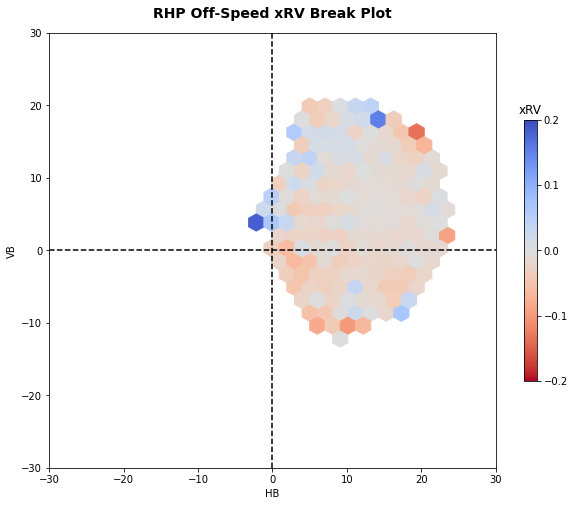

In [25]:
plt.figure(figsize = (10, 8))

plt.hexbin(rhp_os['pfx_x'], rhp_os['pfx_z'], C = rhp_os['xRV'], cmap = 'coolwarm_r',
           mincnt = 10, gridsize = 20)
cb = plt.colorbar(ticks = [-.2,-.1, 0, .1, .2], shrink = .6)
cb.ax.set_title('xRV'), plt.clim(-.2, .2)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('RHP Off-Speed xRV Break Plot', fontsize = 14, fontweight = 'bold', pad = 15);

### LHP Off-Speed Break Plot by xRV

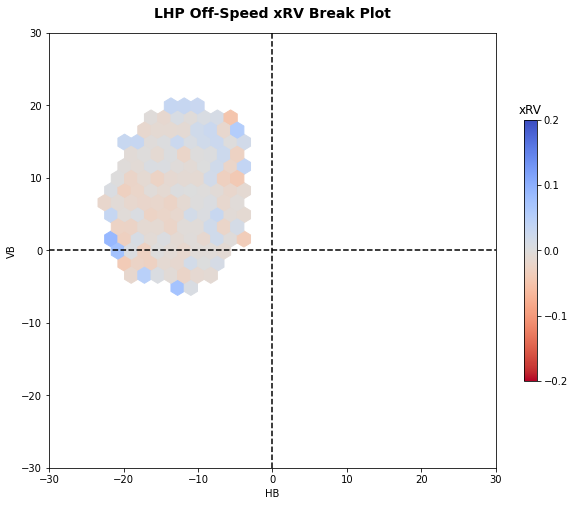

In [26]:
plt.figure(figsize = (10, 8))

plt.hexbin(lhp_os['pfx_x'], lhp_os['pfx_z'], C = lhp_os['xRV'], cmap = 'coolwarm_r',
           mincnt = 10, gridsize = 20)
cb = plt.colorbar(ticks = [-.2,-.1, 0, .1, .2], shrink = .6)
cb.ax.set_title('xRV'), plt.clim(-.2, .2)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('LHP Off-Speed xRV Break Plot', fontsize = 14, fontweight = 'bold', pad = 15);